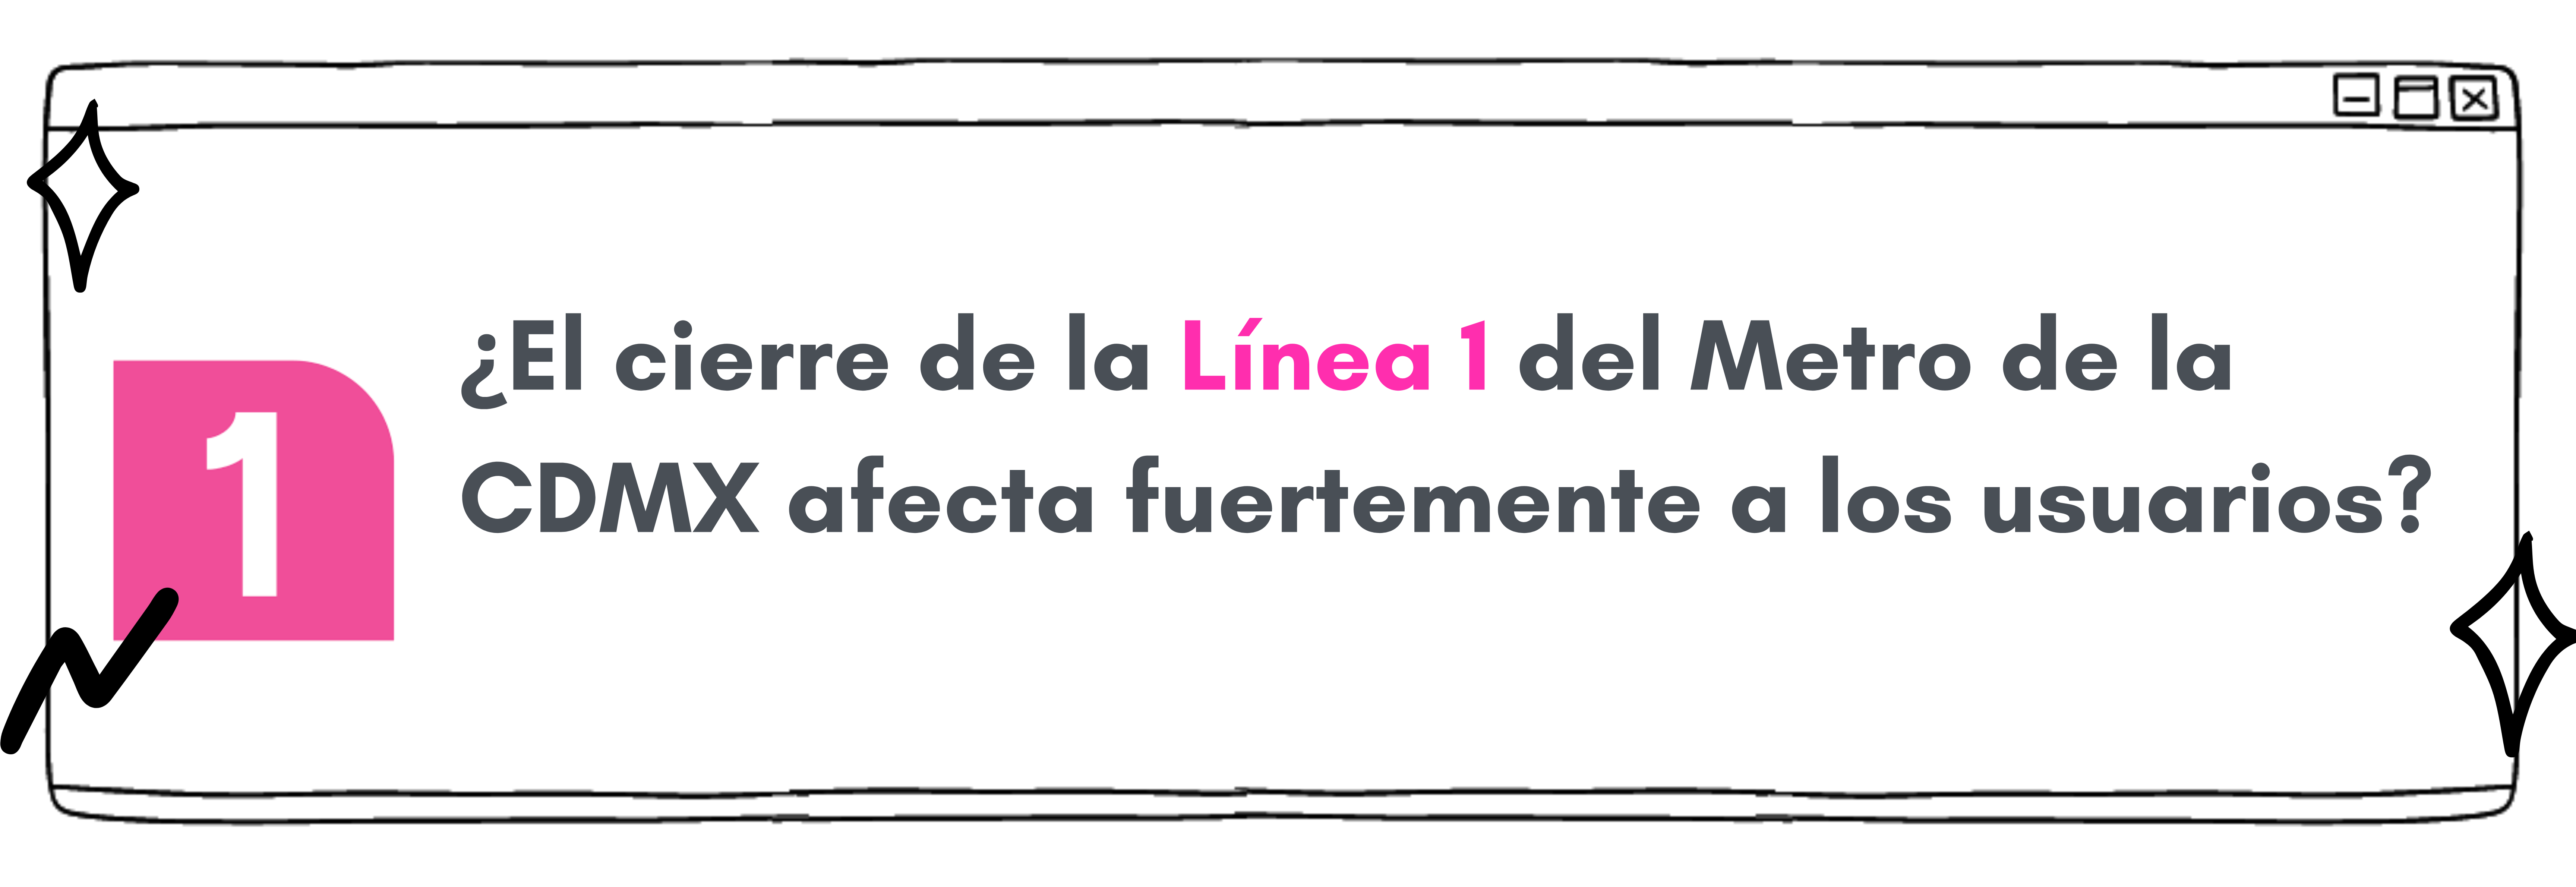

# Proyecto Movilidad. Línea 1 Metro CDMX:

## Resumen

Con motivo del proyecto de [remodelación y modernización](https://www.capital21.cdmx.gob.mx/noticias/?p=14612) del Metro de la CDMX, la Línea 1 del Metro de la  Ciudad de México se encuentra cerrada temporalmente en el tramo que comprende de la terminal de *Pantitlán* a la estación *Salto del Agua*, desde el 11 de julio de 2022.  

Se estima que estará cerrada 8 meses y que, en marzo de 2023, se dará inicio a la renovación de las estaciones restantes(desde la terminal de *Observatorio* a la estación *Balderas*), concluyendo, al fin, en agosto de 2023.  

El Metro es el medio de transporte más importante de la Ciudad de México y la Línea 1, usada diariamente por miles de habitantes, es una de las más importantes... pero ¿sabemos realmente cuánto? 

## Recursos

- Los Datos consultados para la elaboración de este proyecto fueron publicados por el gobierno de esta entidad y pueden consultarse directamente en el [siguiente enlace](https://datos.cdmx.gob.mx/dataset/da3fcf80-f15f-4478-9795-26eddaa6fe86/resource/5d33f9c7-e033-4676-a02d-9e2129017acf/download/afluencia-preliminar-en-transporte-publico.xlsx-afluencia_diaria.csv).
- Versión de Python: 3.7
- Librerías: Pandas, Plotly, Matplotlib, Seaborn

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
link = 'https://drive.google.com/file/d/1F0uobFz8Dcm0KLSO23l6Iwo5uoFHYzKk/view?usp=sharing'
id = '1F0uobFz8Dcm0KLSO23l6Iwo5uoFHYzKk'

archivo = drive.CreateFile({'id':id}) 
archivo.GetContentFile('afluencia-preliminar-en-transporte-publico.xlsx-afluencia_diaria.csv')  
data_afluencia = pd.read_csv('afluencia-preliminar-en-transporte-publico.xlsx-afluencia_diaria.csv')

## Análisis Exploratorio

En un primer vistazo, el DataFrame contiene las siguientes columnas:
- **id:** Índice explícito
- **organismo:** Medio de transporte
- **dia:** Día de la semana
- **fecha:** Fecha en formato calendario
- **afluencia_tarjeta:** Ingresos por tarjeta
- **afluencia_boleto:** Ingresos por boleto
- **afluencia_total_preliminar:** Ingresos totales

In [ ]:
data_afluencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18714 entries, 0 to 18713
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          18714 non-null  int64 
 1   organismo                   18714 non-null  object
 2   linea_servicio              18225 non-null  object
 3   dia                         18714 non-null  object
 4   fecha                       18714 non-null  object
 5   afluencia_tarjeta           2687 non-null   object
 6   afluencia_boleto            3598 non-null   object
 7   afluencia_total_preliminar  18512 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


Las columnas con menos registros nulos son *id*, *organismo*, *día* y *fecha*; mientras que *afluencia_tarjeta* cuenta es la columna con menos información.

En la siguiente gráfica se pueden visualizar el porcentaje de datos nulos por columna:

In [ ]:
null_df = data_afluencia.isnull().sum() / len(data_afluencia) * 100
null_df = pd.DataFrame(null_df, columns= ['porcentaje']).reset_index().round(2)

fig = px.bar(
    null_df,
    title = 'Porcentaje de valores nulos por columna.', 
    height = 400, width = 700,
    x=null_df['index'], 
    y=null_df['porcentaje'],
    labels = {'index': '', 'porcentaje': 'Porcentaje'},
    color='porcentaje',
    color_continuous_scale = 'sunsetdark')
fig.update_layout(paper_bgcolor='light gray')
fig.show()

Es posible también realizar un análisis más exhaustivo de las situaciones específicas a cada organismo, por las que se espera que existan registros nulos:

E.g., no se espera que Ecobici tenga líneas de servicio, dado que es un servicio de renta de bicicletas, ni afluencia por boleto o tarjeta al no funcionar con taquilla.

In [ ]:
def org_nulos (organismo: str):
  '''
  Recibe un organismo como parámetro en formato de cadena y regresa como output una gráfica, donde se observa la distribución de valores nulos
  en todas las columnas del DataFrame, dado el organismo.

  El eje X despliega cada columna, el eje Y muestra el porcentaje de valores nulos que contiene.

  e.g. org_nulos('Metrobús')
  '''
  df = pd.DataFrame(data_afluencia[data_afluencia['organismo'] == organismo])
  fig= px.bar(x = df.columns, y = df.isnull().sum()/df.shape[0]*100,
              title = 'Porcentaje de valores nulos por organismo.', 
              height = 400, width = 700)
  fig.update_layout(paper_bgcolor='light gray')
  return fig.show()

In [ ]:
org_nulos('Ecobici')

Hay una gran cantidad de datos nulos, eliminarlos de tajo para trabajar con un DataFrame limpio es tentador, pero no es recomendable considerando la gran cantidad de información que se pierde:

In [ ]:
experimento_nulos = data_afluencia # Duplica el DataFrame para experimentar sin alterar el original
experimento_nulos = experimento_nulos.dropna(how = 'any')

p_experimento = experimento_nulos.shape[0] / data_afluencia.shape[0] * 100
p_experimento = round(p_experimento, 2)

print(f"El DataFrame conserva apenas el {p_experimento}% de sus registros")

El DataFrame conserva apenas el 14.35% de sus registros


No es conveniente descartar los registros con datos nulos, pero sí explorar la posibilidad de que existan registros duplicados a eliminar antes de comenzar el análisis.

In [ ]:
data_afluencia.duplicated().sum()

0

Por otra parte, es conveniente analizar si existen errores ortográficos que pudieran dejar fuera información relevante, antes de proseguir.

In [ ]:
conteo_mb = data_afluencia[data_afluencia['organismo'] == 'Metrobús'].shape[0]

contiene_mb = data_afluencia[data_afluencia['organismo'].str.contains('etrob')].shape[0] # Omite el acento y la 'M' considerando registros en minúscula

print(f"Existen {conteo_mb} registros de Metrobús y {contiene_mb} registros que contienen la palabra 'Metrobús'")

Existen 3461 registros de Metrobús y 3461 registros que contienen la palabra 'Metrobús'


In [ ]:
data_afluencia['organismo'].unique()

array(['Ecobici', 'Metrobús', 'RTP', 'STC', 'STE-Cablebús',
       'STE-Tren Ligero', 'STE-Trolebús', 'Suburbano'], dtype=object)

Es necesario dar formato adecuado a la *fecha* y convertir a valores numéricos (enteros, por fines prácticos) todas las columnas de afluencia.

In [ ]:
data_afluencia['fecha'] = pd.to_datetime(data_afluencia['fecha'])

data_afluencia['afluencia_tarjeta'] = data_afluencia['afluencia_tarjeta'].str.replace(",", "")
data_afluencia['afluencia_boleto'] = data_afluencia['afluencia_boleto'].str.replace(",", "")
data_afluencia['afluencia_total_preliminar'] = data_afluencia['afluencia_total_preliminar'].str.replace(",", "")

data_afluencia['afluencia_tarjeta'] = pd.to_numeric(data_afluencia['afluencia_tarjeta']).fillna(value=0).astype(int)
data_afluencia['afluencia_boleto'] = pd.to_numeric(data_afluencia['afluencia_boleto']).fillna(value=0).astype(int)
data_afluencia['afluencia_total_preliminar'] = pd.to_numeric(data_afluencia['afluencia_total_preliminar']).fillna(value=0).astype(int)

In [ ]:
data_afluencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18714 entries, 0 to 18713
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          18714 non-null  int64         
 1   organismo                   18714 non-null  object        
 2   linea_servicio              18225 non-null  object        
 3   dia                         18714 non-null  object        
 4   fecha                       18714 non-null  datetime64[ns]
 5   afluencia_tarjeta           18714 non-null  int64         
 6   afluencia_boleto            18714 non-null  int64         
 7   afluencia_total_preliminar  18714 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.1+ MB


Tras haber convertido las fechas al formato *datetime*, es posible aplicarles los atributos de este tipo de datos: weekday muestra el día de la semana, day el día del mes.    

In [ ]:
data_afluencia['fecha'].dt.weekday

0        6
1        0
2        1
3        2
4        3
        ..
18709    0
18710    1
18711    2
18712    3
18713    4
Name: fecha, Length: 18714, dtype: int64

In [ ]:
data_afluencia['fecha'].dt.day

0         1
1         2
2         3
3         4
4         5
         ..
18709    28
18710    29
18711    30
18712     1
18713     2
Name: fecha, Length: 18714, dtype: int64

El Sistema de Transporte Colectivo (Metro), enlistado como *STC*, es el organismo más utilizado con un total de afluencia de 1,022,922,255. A su vez, la Línea 1 del Metro es la más utilizada, con una afluenci a total de 156,984,799.

Tienen también los registros más altos dentro de sus respectivas categorias.

In [ ]:
data_afluencia.groupby('organismo')['afluencia_total_preliminar'].agg(['sum','count', 'max']).sort_values('sum', ascending = False)

,sum,count,max
organismo,,,
STC,1022922255,5868,874324
Metrobús,301902718,3461,545082
RTP,90930827,3671,220754
STE-Trolebús,44246028,4126,92150
Suburbano,32609321,489,197740
STE-Tren Ligero,12306738,489,105281
Ecobici,4672818,489,31855
STE-Cablebús,385048,121,7897


In [ ]:
data_afluencia.groupby(['organismo', 'linea_servicio'])['afluencia_total_preliminar'].agg(['sum','count', 'max']).sort_values('sum', ascending = False)

sum  \
organismo       linea_servicio                                                 
STC             L1                                                 156984799   
                L2                                                 139362943   
                L3                                                 130511082   
                LB                                                 101715310   
Metrobús        L1                                                  92624682   
STC             L8                                                  90264901   
                LA                                                  83532311   
                L12                                                 78835682   
                L9                                                  78760298   
                L7                                                  61453677   
                L5                                                  55510462   
RTP             Ordinario                                           45580256   
Metrobús        L6                                                  43732564   
                L2                                                  42107954   
                L5                                                  39085904   
                L3                                                  38305228   
Suburbano       L1                                                  32609321   
STC             L6                                                  28156650   
Metrobús        L7                                                  28028901   
RTP             Expreso                                             24647012   
STE-Trolebús    L1 Eje Central                                      22888645   
STC             L4                                                  17834140   
Metrobús        L4                                                  17415848   
STE-Tren Ligero Xochimilco-Tasqueña                                 12306738   
RTP             Ecobús                                               9181715   
                Atenea                                               4765065   
STE-Trolebús    L4 Pto Aéreo-Rosario                                 4632121   
                L7 Lomas Estrella-CU                                 4558353   
RTP             SEFI Metro Línea 12                                  3392169   
STE-Trolebús    L2 Eje 2 sur                                         3123695   
                L3 Eje 7 Sur                                         2997578   
                L5 Sn Felipe-Hidalgo                                 2963173   
                L6 Rosario-Chapultepec                               2382278   
RTP             SEFI Metro                                           2159852   
STE-Trolebús    L9 Iztacalco-Villa de Cortés                          624598   
Metrobús        LT1 (Atlalilco-Tláhuac)                               514385   
STE-Cablebús    L1 Campos Revolución-Tlalpexco                        385048   
RTP             Expreso Directo                                       368123   
                Nocturno                                              245724   
                Eco Atenea                                            186653   
                Temporal Zaragoza-Tacuba                              166094   
                Temporal Peñón-Panteón San Isidro-Metro Camarones     135717   
Metrobús        LT2 (Coyuya-Tláhuac)                                   87252   
STE-Trolebús    L8 Circuito IPN                                        75587   
RTP             Temporal Tlalpan-Xochimilco                            52560   
                Temporal Viveros-Tetelpan                              49887   
STE-Trolebús    Servicio apoyo Metro Línea 12                              0   

                                                                   count  \
organismo       linea_servicio                                             


En las líneas de servicio hay enlistados servicios temporales, es conveniente corroborar si estos servicios conforman un porcentaje importante de las lineas a analizar. No es así, con apenas 4 rutas temporales. 

In [ ]:
temp = data_afluencia[data_afluencia['linea_servicio'].str.contains('emporal', na=False)] # Omite la mayúscula, considerando coincidencias en minúsculas
temp['linea_servicio'].nunique()

array(['Temporal Peñón-Panteón San Isidro-Metro Camarones',
       'Temporal Zaragoza-Tacuba', 'Temporal Tlalpan-Xochimilco',
       'Temporal Viveros-Tetelpan'], dtype=object)

Los martes son los días con más afluencia en el transporte público de la ciudad.

In [ ]:
data_afluencia.groupby('dia')['afluencia_total_preliminar'].agg(['sum','count', 'max']).sort_values('sum', ascending = False)

,sum,count,max
dia,,,
Martes,239477843,2681,820067
Jueves,238240944,2681,802291
Viernes,237182340,2681,874324
Lunes,228317986,2679,770843
Miércoles,202951991,2267,807048
Sábado,197344970,2638,747252
Domingo,128866694,2674,454374
Míercoles,37592985,413,303257


Las afluencia por tarjeta, por boleto y total se concentran en los valores más bajos y se  distibuyen de la siguiente manera:

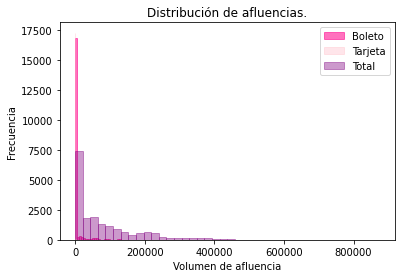

In [ ]:
plt.hist(data_afluencia['afluencia_boleto'], edgecolor='#FF1493', color='#FF1493', alpha=0.6, bins = 40, label='Boleto')
plt.hist(data_afluencia['afluencia_tarjeta'], edgecolor='pink', color = 'pink', alpha=0.4, bins = 40, label='Tarjeta')
plt.hist(data_afluencia['afluencia_total_preliminar'], edgecolor='purple', color = 'purple', alpha=0.4, bins = 40, label='Total')

plt.title('Distribución de afluencias.')
plt.legend(loc='best')
plt.xlabel('Volumen de afluencia')
plt.ylabel('Frecuencia')
plt.show()

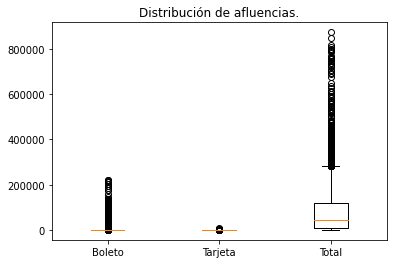

In [ ]:
data_1 = data_afluencia['afluencia_boleto']
data_2 = data_afluencia['afluencia_tarjeta']
data_3 = data_afluencia['afluencia_total_preliminar']
 
plt.boxplot([data_afluencia['afluencia_boleto'], data_afluencia['afluencia_tarjeta'], data_afluencia['afluencia_total_preliminar']],
            patch_artist = False, labels = ['Boleto', 'Tarjeta', 'Total'])
plt.title('Distribución de afluencias.')
plt.show()

Para visualizar en un mapa de calor cómo se distribuyen los registros entre cada organismo en cada día de la semana, es necesario reordenar los datos. Así, el Metro en viernes es la intersección con mayor número de usuarios.

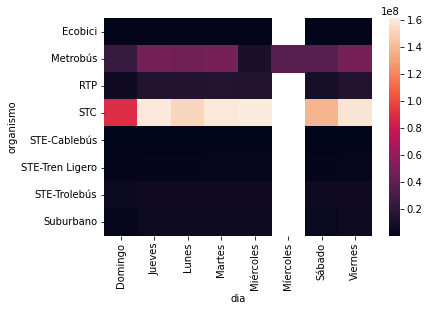

In [ ]:
dia_org = data_afluencia.groupby(['organismo', 'dia'], as_index = False).agg({'afluencia_total_preliminar': 'sum'})

heat_dia_org = dia_org.pivot(index = 'organismo', columns ='dia', values = 'afluencia_total_preliminar')
sns.heatmap(heat_dia_org)

Aquí se aprecia cómo es que se distribuye la afluencia por organismos y líneas, dejando clara la importancia de la Línea 1 del Metro en el siguiente mapa de calor: 

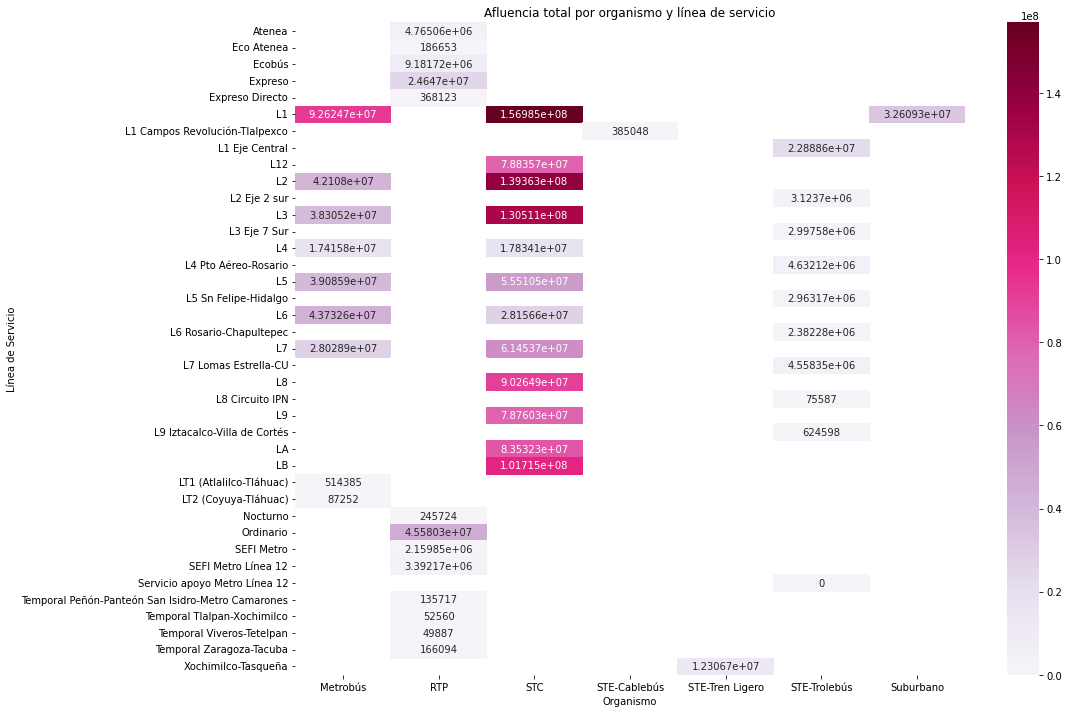

In [ ]:
linea_org = data_afluencia.groupby(['organismo', 'linea_servicio'], as_index = False).agg({'afluencia_total_preliminar': 'sum'}).sort_values(['afluencia_total_preliminar'],ascending=False)

plt.figure(figsize = (15,12))

heat_linea_org = linea_org.pivot(index = 'linea_servicio', columns ='organismo', values = 'afluencia_total_preliminar')
heat_linea_orgg = sns.heatmap(heat_linea_org, annot= True, cmap='PuRd', fmt='g')

heat_linea_orgg.set(xlabel='Organismo', ylabel='Línea de Servicio', title = 'Afluencia total por organismo y línea de servicio')

heat_linea_orgg

Otra manera de visualizar esta información es directamente en los porcentajes de afluencia total de cada línea del Metro; la Línea 1 encabeza la lista con un 15.35%

In [ ]:
linea_stc = data_afluencia[data_afluencia['organismo'] == 'STC']
linea_stc = linea_stc.groupby('linea_servicio')['afluencia_total_preliminar'].sum().sort_values(ascending=False)

linea_stc = linea_stc /linea_stc.sum().sum() * 100
linea_stc.round(2)

linea_servicio
L1     15.35
L2     13.62
L3     12.76
LB      9.94
L8      8.82
LA      8.17
L12     7.71
L9      7.70
L7      6.01
L5      5.43
L6      2.75
L4      1.74
Name: afluencia_total_preliminar, dtype: float64

Otro factor a considerar es que en marzo del 2020 se declaró la emergencia sanitaria por Covid 19 en la Ciudad de México, promoviendo el que sus habitantes permanecieran en casa. Este fenómeno afectó la afluencia de usuarios, como se puede ver a continuación:

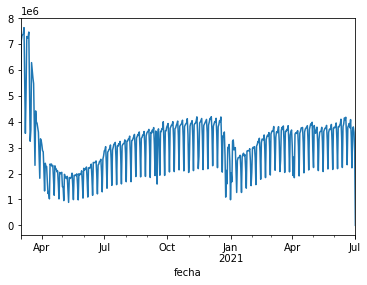

In [ ]:
data_afluencia.groupby('fecha')['afluencia_total_preliminar'].sum().plot()

Toda esta información es suficiente para poder asegurar sin lugar a duda la importancia de la Línea 1 del Metro de la CDMX, esta vez con el respaldo de datos relevantes.
El cierre temporal de la Línea 1 del Metro de la CDMX impactará fuertemente a sus usuarios.

Ha quedado claro el impacto del cierre temporal del Metro, afortunadamente Python, al ser un lenguaje orientado a objetos, puede ayudarnos con esto y darnos un metro que no esté sujeto a ningún cierre.
Este metro ilustrará todas las siguientes caracteristicas:

- Métodos  
- Atributos  
- Herencia  
- Polimorfismo  
- Encapsulación  

In [ ]:
class tren_metro:
  '''
  Esta clase define el comportamiento de un tren promedio en el STC de la Ciudad de México

  Sus atributos de clase son el peso y color. Estas características son compartidas por todo tren.
  Sus atributos de instancia son únicos para cada objeto: línea, aceleración y velocidad

  acelerar() modifica el atributo de velocidad del objeto al sumarle la aceleración del tren
  frenar() modifica el atributo de velocidad del objeto al asignarle el valor de cero

  Ejemplo de utilización:
  tren_metro(1, 36)
  '''
  peso = 28.9 * 9 # Todo tren tiene 9 vagones, cada vagón pesa 28.9 toneladas
  color = 'Naranja'

  def __init__(self, linea, aceleracion):
    self.linea = linea # Cada tren pertenece a una línea distinta
    self.aceleracion = aceleracion
    self.velocidad = 0

  def acelerar(self):
    self.velocidad = self.velocidad + self.aceleracion
    return self.velocidad

  def frenar(self):
    if self.velocidad > 0:
      self.velocidad = 0
    return self.velocidad

class tren_bala(tren_metro):
  '''
  Esta clase define el comportamiento de un tren bala súper veloz basado en el STC de la Ciudad de México.

  Hereda el atributo de clase de color, mientras que su peso está disminuido en 10 T por vagón. 
  Estas características son compartidas por todo tren bala; sus atributos de instancia son aceleración y velocidad

  Hereda también sus métodos de acelerar() y frenar():
  acelerar() modifica el atributo de velocidad del objeto al sumarle la aceleración del tren
  frenar() modifica el atributo de velocidad del objeto al asignarle el valor de cero

  Ejemplo de utilización:
  tren_bala(36)
  '''
  peso = 18.9 * 9

  def __init__(self, aceleracion):
    self.aceleracion = aceleracion + 50
    self.velocidad = 0

In [ ]:
def freno_total(trenes): # Referencia a instancias de diferentes clases.
    for tren in trenes:
        tren.frenar()

if __name__ == '__main__':
    tren_metro = tren_metro('L1', 36)
    tren_bala = tren_bala(36)
    dos_trenes = [tren_metro, tren_bala]
    freno_total(dos_trenes)

# Hola, mi nombre es Sarahí Sancliment 👋

## 🚀 Acerca de mí
Soy analista de datos en proceso, con experiencia en la investigación académica en el área de la Filosofía y las Ciencias Sociales. Tengo el ojo bien puesto en llevar esos talentos al mundo de la programación.

## 🔗 ¿Platicamos?
### sasn6970@protonmail.com 
#### (+52) 55-3247-2299
[![linkedin](https://img.shields.io/badge/linkedin-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/sara-sancliment-garcia-4336b1235/)
[![github](https://img.shields.io/badge/github-1DA1F2?style=for-the-badge&logo=github&logoColor=white)](https://github.com/sasn6970)